In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

ModuleNotFoundError: No module named 'seaborn'

In [2]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df = data[(data['ocean_proximity'] == '<1H OCEAN') | (data['ocean_proximity'] == 'INLAND')]
df = df.fillna(0)

df['median_house_value'] = np.log1p(df['median_house_value'])

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [5]:
assert len(df) == len(df_train) + len(df_val) + len(df_test)
assert len(df_val) == len(df_test)

In [6]:
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`


In [7]:
dr = DecisionTreeRegressor(max_depth=1)
dr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

[Text(0.5, 0.75, 'ocean_proximity=<1H OCEAN <= 0.5\nsquared_error = 0.322\nsamples = 9411\nvalue = 12.011'),
 Text(0.25, 0.25, 'squared_error = 0.23\nsamples = 3924\nvalue = 11.607'),
 Text(0.75, 0.25, 'squared_error = 0.186\nsamples = 5487\nvalue = 12.301')]

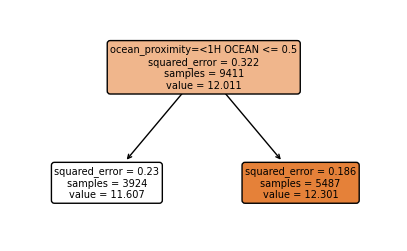

In [8]:
feature_names = list(dv.get_feature_names_out())
plt.figure(figsize=(5,3))
plot_tree(dr, feature_names=feature_names, filled=True, rounded=True)

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [9]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.24495290030597147

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- 160

In [10]:
scores = []
for est in tqdm(range(10,201, 10)):
    rf = RandomForestRegressor(n_estimators=est, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((est, rmse))

100%|███████████████████████████████████████████| 20/20 [03:56<00:00, 11.80s/it]


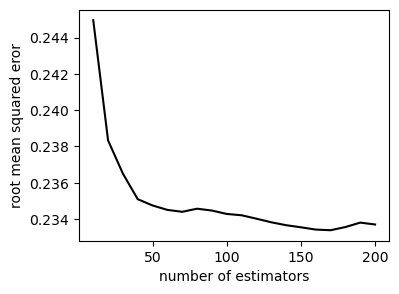

In [11]:
df_scores = pd.DataFrame(scores, columns=['n_est', 'rmse'])

plt.figure(figsize=(4,3))
plt.plot(df_scores.n_est, df_scores.rmse, color='black')
plt.xlabel('number of estimators')
plt.ylabel('root mean squared eror')
plt.show()

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [12]:
scores = []

for depth in tqdm([10, 15, 20, 25]):
    for est in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=depth ,n_estimators=est, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        
        scores.append((depth, est, rmse))

100%|████████████████████████████████████████████| 4/4 [39:19<00:00, 589.80s/it]


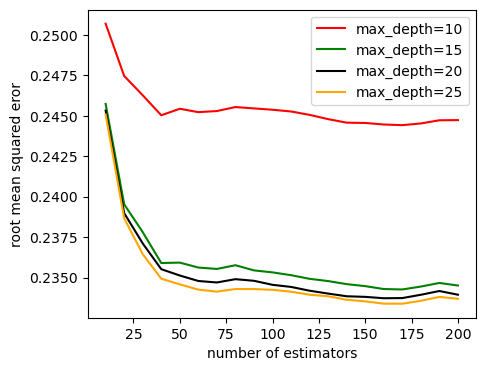

In [13]:
df_scores = pd.DataFrame(scores, columns=['depth', 'n_est', 'rmse'])
colors = ['Red', 'Green', 'Black','Orange']
plt.figure(figsize=(5,4))

for c, depth in zip(colors, [10, 15, 20, 25]):
    df_subset = df_scores[df_scores['depth']==depth]
    plt.plot(df_subset.n_est, df_subset.rmse, label=f'max_depth={depth}', color=c)
    
    
plt.xlabel('number of estimators')
plt.ylabel('root mean squared eror')
plt.legend()
plt.show()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`



In [14]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
scores = []
feature_names = dv.get_feature_names_out()
importances = rf.feature_importances_

for feature, importance in zip(feature_names, importances):
    scores.append((feature, importance))
    
df_scores = pd.DataFrame(scores, columns=['feature', 'importance'])
df_scores.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.335668
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101891
3,longitude,0.086176
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030194
7,population,0.026821
9,total_rooms,0.021772
8,total_bedrooms,0.016245
0,households,0.014953


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [99]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [120]:
features = dv.get_feature_names_out().tolist()
features = [i.replace("=<", "_").replace("=","_") for i in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [121]:
scores = {}

In [122]:
evals_results = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=False, evals_result=evals_results, num_boost_round =200)

train_rmse = evals_results['train']['rmse']
val_rmse = evals_results['val']['rmse']

scores['eta=0.3'] = pd.DataFrame({'train_rmse': train_rmse, 'val_rmse': val_rmse})

In [123]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [124]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [125]:
evals_result = {}
watchlist = [(dtrain, 'train'),(dval, 'val')]

model = xgb.train(xgb_params, dtrain, verbose_eval=False, evals_result=evals_result, num_boost_round=200, evals=watchlist)

train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['val']['rmse']

scores['eta=0.1'] = pd.DataFrame({'train_rmse': train_rmse, 'val_rmse': val_rmse})

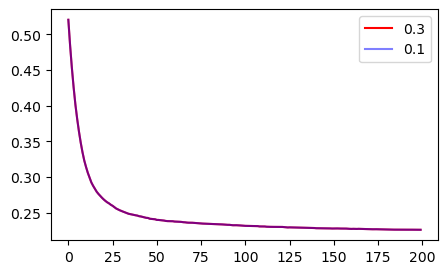

In [150]:
plt.figure(figsize=(5, 3))
plt.plot(scores['eta=0.3'].val_rmse, label='0.3', color='red')
plt.plot(scores['eta=0.1'].val_rmse, label='0.1', alpha=0.5, color='blue')
plt.legend()
plt.show()

In [ ]:
xgb.pr